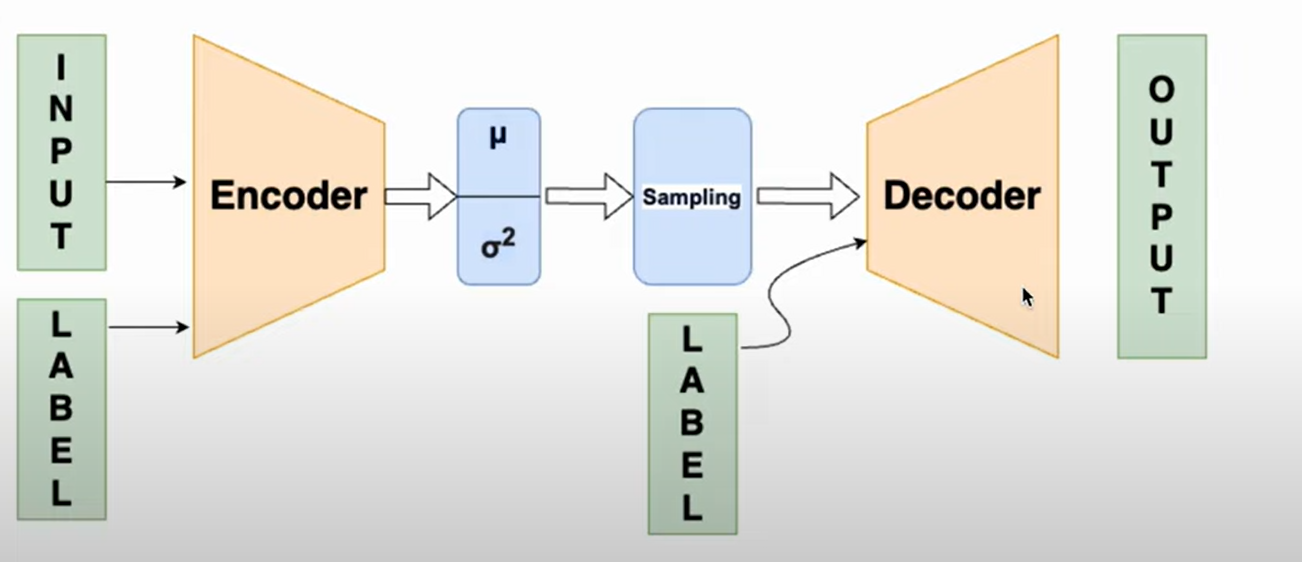

In [31]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt

In [32]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

In [33]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

In [34]:
batch_size = 128
num_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_labels = 10

In [35]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [36]:
image, label = train_data[0]
image.shape

torch.Size([1, 28, 28])

In [37]:
def sampling(z_mean, z_log_variance):
  batch_size, dim = z_mean.shape
  epsilon = torch.randn(batch_size, dim, device=z_mean.device)
  return z_mean + torch.exp(z_log_variance/2) * epsilon

In [38]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=2, out_channels=16, kernel_size=3, stride=2, padding=1)
    self.activation1 = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
    self.activation2 = nn.ReLU()
    self.fc = nn.Linear(32 * 7 * 7, 16)
    self.activation3 = nn.ReLU()

    self.mean = nn.Linear(16, 2)
    self.log_variance = nn.Linear(16, 2)
    self.label = nn.Linear(10, 28 * 28)

  def forward(self, x, y):
    y = self.label(y) #784
    y = y.view(y.shape[0], 1, 28, 28) #1x28x28
    x = torch.cat((x, y), dim=1) #2x28x28

    x = self.activation1(self.conv1(x)) #16x14x14
    x = self.activation2(self.conv2(x) ) #32x7x7
    x = x.view(x.shape[0], -1) #1568
    x = self.activation3(self.fc(x)) #16

    z_mean = self.mean(x) #2
    z_log_variance = self.log_variance(x) #2

    return z_mean, z_log_variance

In [39]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.fc = nn.Linear(12, 32 * 7 * 7)
    self.convt1 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1)
    self.activation1 = nn.ReLU()
    self.convt2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1)
    self.activation2 = nn.ReLU()
    self.convt3 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)
    self.activation3 = nn.Sigmoid()

  def forward(self, x, y):
    x = torch.cat((x, y), dim=1) #12

    x = self.fc(x) #1568
    x = x.view(x.shape[0], 32, 7, 7) #32x7x7
    x = self.activation1(self.convt1(x)) #32x14x14
    x = self.activation2(self.convt2(x)) #16x28x28
    x = self.activation3(self.convt3(x)) #1x28x28

    return x

In [52]:
class CVAE(nn.Module):
  def __init__(self):
    super(CVAE, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

  def forward(self, x, y):
    y = nn.functional.one_hot(y, num_classes=num_labels).to(torch.float32)
    z_mean, z_log_variance = self.encoder(x, y)
    z = sampling(z_mean, z_log_variance)
    x = self.decoder(z, y)

    return z_mean, z_log_variance, x

In [53]:
def calculate_loss(output, image, z_mean, z_log_variance):
    reconstruction_loss = nn.functional.mse_loss(output, image, reduction='sum') / (image.shape[0])

    kl_divergence = -0.5 * torch.sum(1 + z_log_variance - z_mean.pow(2) - torch.exp(z_log_variance)) / image.shape[0]

    loss = reconstruction_loss + kl_divergence
    return loss

In [54]:
model = CVAE()
model.to(device)

CVAE(
  (encoder): Encoder(
    (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (activation1): ReLU()
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (activation2): ReLU()
    (fc): Linear(in_features=1568, out_features=16, bias=True)
    (activation3): ReLU()
    (mean): Linear(in_features=16, out_features=2, bias=True)
    (log_variance): Linear(in_features=16, out_features=2, bias=True)
    (label): Linear(in_features=10, out_features=784, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=12, out_features=1568, bias=True)
    (convt1): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (activation1): ReLU()
    (convt2): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (activation2): ReLU()
    (convt3): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation3): Sigmoid()
  )
)

In [55]:
optim = torch.optim.Adam(model.parameters())

In [56]:
for epoch in range(num_epochs):
  running_loss = 0.0
  count = 0
  for image, label in train_loader:
    image = image.to(device)
    label = label.to(device)

    z_mean, z_log_variance, output = model(image, label)

    loss = calculate_loss(output, image, z_mean, z_log_variance)

    optim.zero_grad()
    loss.backward()
    optim.step()

    running_loss += loss.item()
    count += 1

  print(f'Epoch: {epoch + 1}, Training Loss: {running_loss/count:.4f}')

Epoch: 1, Training Loss: 47.9861
Epoch: 2, Training Loss: 34.9258
Epoch: 3, Training Loss: 32.0876
Epoch: 4, Training Loss: 31.4721
Epoch: 5, Training Loss: 31.0879
Epoch: 6, Training Loss: 30.8676
Epoch: 7, Training Loss: 30.6697
Epoch: 8, Training Loss: 30.5301
Epoch: 9, Training Loss: 30.4304
Epoch: 10, Training Loss: 30.3609
Epoch: 11, Training Loss: 30.2818
Epoch: 12, Training Loss: 30.2487
Epoch: 13, Training Loss: 30.1913
Epoch: 14, Training Loss: 30.1489
Epoch: 15, Training Loss: 30.1051
Epoch: 16, Training Loss: 30.0791
Epoch: 17, Training Loss: 30.0600
Epoch: 18, Training Loss: 30.0166
Epoch: 19, Training Loss: 29.9806
Epoch: 20, Training Loss: 29.9652
Epoch: 21, Training Loss: 29.9397
Epoch: 22, Training Loss: 29.9196
Epoch: 23, Training Loss: 29.8946
Epoch: 24, Training Loss: 29.8820
Epoch: 25, Training Loss: 29.8631
Epoch: 26, Training Loss: 29.8569
Epoch: 27, Training Loss: 29.8416
Epoch: 28, Training Loss: 29.8291
Epoch: 29, Training Loss: 29.7974
Epoch: 30, Training Los

In [58]:
with torch.no_grad():
  running_loss = 0.0
  count = 0
  for image, label in train_loader:
    image = image.to(device)
    label = label.to(device)

    z_mean, z_log_variance, output = model(image, label)

    loss = calculate_loss(output, image, z_mean, z_log_variance)

    running_loss += loss.item()
    count += 1

  print(f'Testing Loss: {running_loss/count:.4f}')

Testing Loss: 29.7358


In [75]:
def plt_imgs(imgs):
  _, axs = plt.subplots(5, 5, figsize=(10, 10))
  axs = axs.flatten()

  for img, ax in zip(imgs, axs):
    ax.imshow(img.cpu().squeeze().numpy(), cmap='gray')

  plt.show()

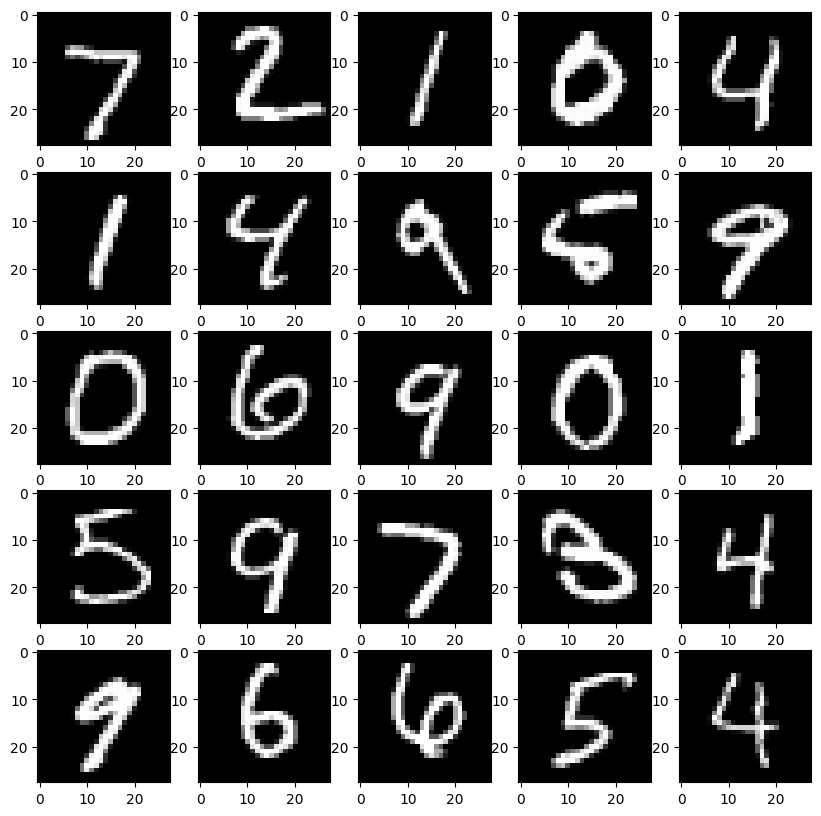

In [76]:
data_items = [test_data[i] for i in range(25)]
images = [item[0] for item in data_items]
labels = [item[1] for item in data_items]
plt_imgs(images)

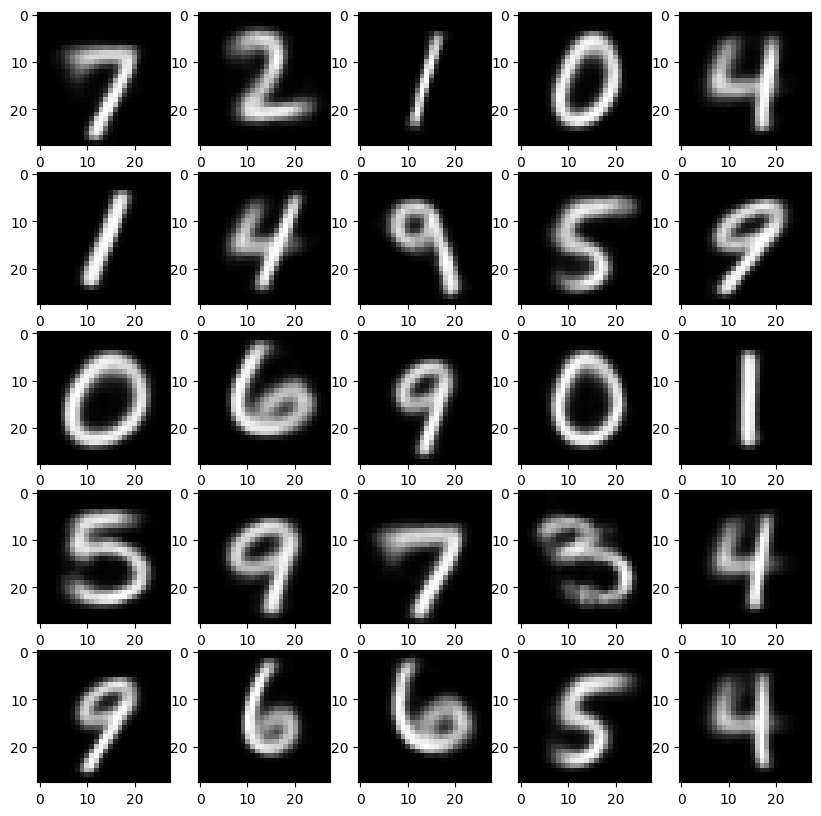

In [80]:
with torch.no_grad():
  predicted_images = model(torch.stack(images).to(device), torch.tensor(labels).to(device))[2]
  plt_imgs(predicted_images)